# Airbnb DS Analytics
The purpose of this project is to analyze and identify opportunity areas and grow bookings in Rio de Janeiro. 

### OKR
#### Objective 1 - Improving the guest-host matching process
#### Objective 2 - Identifying areas of opportunities to increase bookings

In [1]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Import Data

In [2]:
# Contains row for every time that a user makes an inquiry for a stay at a listing - Parsing date columns
contacts_df = pd.read_csv('data/contacts.csv', 
                          parse_dates=['ts_interaction_first', 'ts_reply_at_first', 'ts_accepted_at_first', 
                                       'ts_booking_at', 'ds_checkin_first', 'ds_checkout_first']) 

# Contains data for every listing in the market
listings_df = pd.read_csv('data/listings.csv')

# Contains data for every user
users_df = pd.read_csv('data/users.csv')

## 2. Contacts
- Understanding dataset.
- Visualizing three different user groups and their booking types (contact_me, book_me, and instant_book).
- Visualizing three different user groups' booking experience (inquiry to booking).
- Visualizing host response rate to guests' inquiries and text characteristics.
- Visualizing whether more interactions yields higher response/acceptance/booking rate.

### 2.1 Understanding dataset

In [3]:
contacts_df.describe()

,m_guests,m_interactions,m_first_message_length_in_characters
count,27886.000000,27887.000000,27887.000000
mean,2.782041,8.255818,193.712626
std,1.863797,10.035784,183.172132
min,0.000000,1.000000,0.000000
25%,2.000000,3.000000,66.000000
50%,2.000000,5.000000,154.000000
75%,4.000000,10.000000,269.000000
max,16.000000,410.000000,2341.000000


In [4]:
# Check datatype
contacts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27887 entries, 0 to 27886
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   id_guest_anon                         27887 non-null  object        
 1   id_host_anon                          27887 non-null  object        
 2   id_listing_anon                       27887 non-null  object        
 3   ts_interaction_first                  27887 non-null  datetime64[ns]
 4   ts_reply_at_first                     25855 non-null  datetime64[ns]
 5   ts_accepted_at_first                  16415 non-null  datetime64[ns]
 6   ts_booking_at                         11587 non-null  datetime64[ns]
 7   ds_checkin_first                      27887 non-null  datetime64[ns]
 8   ds_checkout_first                     27887 non-null  datetime64[ns]
 9   m_guests                              27886 non-null  float64       
 10

In [5]:
# Checking for NaNs
contacts_df.isna().sum()

id_guest_anon                               0
id_host_anon                                0
id_listing_anon                             0
ts_interaction_first                        0
ts_reply_at_first                        2032
ts_accepted_at_first                    11472
ts_booking_at                           16300
ds_checkin_first                            0
ds_checkout_first                           0
m_guests                                    1
m_interactions                              0
m_first_message_length_in_characters        0
contact_channel_first                       0
guest_user_stage_first                      0
dtype: int64

In [6]:
missing_percentage = contacts_df.isna().sum() * 100 / len(contacts_df)
missing_percentage

id_guest_anon                            0.000000
id_host_anon                             0.000000
id_listing_anon                          0.000000
ts_interaction_first                     0.000000
ts_reply_at_first                        7.286549
ts_accepted_at_first                    41.137448
ts_booking_at                           58.450174
ds_checkin_first                         0.000000
ds_checkout_first                        0.000000
m_guests                                 0.003586
m_interactions                           0.000000
m_first_message_length_in_characters     0.000000
contact_channel_first                    0.000000
guest_user_stage_first                   0.000000
dtype: float64

Majority of NaN values are comming from *ts_accepted_at_first* and *ts_booking_at* columns.

There are four columns that contains NaT values:
- **ts_reply_at_first**: UTC timestamp of the moment the host replies to the inquiry.
- **ts_accepted_at_first**: UTC timestamp of the moment the host accepts the inquiry.
- **ts_booking_at**: UTC timestamp of the moment the host booking is made.
- **m_guests**: Number of guests the inquiry is for.

In [7]:
# Checking all columns with NaT
contacts_df[contacts_df.isna().any(axis=1)].head(5)

,id_guest_anon,id_host_anon,id_listing_anon,ts_interaction_first,ts_reply_at_first,ts_accepted_at_first,ts_booking_at,ds_checkin_first,ds_checkout_first,m_guests,m_interactions,m_first_message_length_in_characters,contact_channel_first,guest_user_stage_first
1,8590d6f1-8bc9-4e8b-bdfb-de78f69fcf37,f30417c5-6df4-45ac-bfc2-6ad1cce398ab,e387c705-0aeb-464c-9375-ece63be6f006,2016-02-16 22:14:01,2016-02-16 23:37:36,NaT,NaT,2016-08-11,2016-08-22,5.0,2,312.0,contact_me,past_booker
2,ebcd83ba-bda1-47eb-9680-2dd04ccf3988,13cbf50a-3272-45d4-9866-a06b6ea1b99a,d1eb1960-938f-4305-a353-51e224414dd4,2016-01-27 23:33:38,2016-01-28 02:12:47,NaT,NaT,2016-03-14,2016-03-23,1.0,3,164.0,contact_me,new
3,b0af8848-fe2a-4ef1-991e-26ab3066feb3,01614601-d5a4-4776-ab9b-c10d3b865bf0,855f6779-346c-45fc-a64b-ea133250ca7a,2016-05-05 14:42:52,2016-05-05 15:17:40,2016-05-05 15:17:40,NaT,2016-05-27,2016-05-29,2.0,3,203.0,contact_me,new
5,25940fca-7aa9-480d-9cf0-56cc1136d30c,90334ef3-f489-45a0-89e0-d18d370e4a1c,5dd24057-774c-45b3-b305-ebf664246952,2016-04-19 07:08:21,2016-04-19 11:32:23,NaT,NaT,2016-04-26,2016-05-01,1.0,7,348.0,contact_me,new
6,ee6633e1-96de-47f6-96e7-d962fc6db7dd,10dc3fc4-694f-44b2-aaac-9dbace0ebabd,259d4a6c-dcda-4ff2-85cb-2882f6801b3a,2016-05-30 15:16:21,2016-05-30 15:18:55,2016-06-01 23:38:20,NaT,2016-08-06,2016-08-14,6.0,7,29.0,contact_me,past_booker


In [8]:
# Check one row where m_guests has NaT value
contacts_df[contacts_df['m_guests'].isna()].head()

,id_guest_anon,id_host_anon,id_listing_anon,ts_interaction_first,ts_reply_at_first,ts_accepted_at_first,ts_booking_at,ds_checkin_first,ds_checkout_first,m_guests,m_interactions,m_first_message_length_in_characters,contact_channel_first,guest_user_stage_first
24738,abc1b137-28b0-4337-a93c-ed77c16f49d8,1a260779-97eb-4c3f-a020-c09a094033a4,f4ada617-3298-4c78-97ee-104edd981e09,2016-01-11 12:08:54,2016-01-12 17:48:59,NaT,NaT,2016-01-22,2016-01-25,NaN,3,134.0,contact_me,past_booker


In [9]:
# Displaying rows with NaT values
contacts_df[contacts_df['ts_reply_at_first'].isna()].head()

,id_guest_anon,id_host_anon,id_listing_anon,ts_interaction_first,ts_reply_at_first,ts_accepted_at_first,ts_booking_at,ds_checkin_first,ds_checkout_first,m_guests,m_interactions,m_first_message_length_in_characters,contact_channel_first,guest_user_stage_first
16,bcd2c6bb-c5bf-484a-9cfc-ba13b8a0a9be,d5bcd535-92a1-4337-9148-6b53ce87c311,7e367f14-45a8-4a7c-a328-3e151cf71fed,2016-01-07 06:12:42,NaT,NaT,NaT,2016-08-08,2016-08-18,3.0,2,196.0,book_it,new
30,57a896e1-95cb-4682-8ff9-7780817b1fbe,fd1d1258-12a6-4996-9313-d227328ad612,2383653d-1c82-4426-a3ea-e8e47052f4c5,2016-01-22 11:13:42,NaT,NaT,NaT,2016-02-06,2016-02-09,4.0,2,83.0,contact_me,past_booker
33,6faf4e06-aecd-4401-9c1e-a688bae85e22,d872b6fe-f1d1-403c-8392-55bfa9fabf45,263a9917-524d-4862-8dd6-76c56f0986bd,2016-06-29 01:35:06,NaT,NaT,NaT,2016-08-06,2016-08-19,1.0,1,201.0,book_it,past_booker
42,fc49dae9-f3e1-418a-9e34-3e73e54a89fc,a3803a5b-5a5d-444f-a0a6-a03ed6a9e845,c92711bf-23a0-4527-99c2-08bad0f61484,2016-04-01 14:08:56,NaT,NaT,NaT,2016-08-12,2016-08-18,6.0,1,240.0,book_it,past_booker
124,0b55d884-f528-47df-935f-e766d7059562,45f6c9de-675f-4549-b163-5d27e362b905,aa542203-87fe-4375-a76f-b8c54cd4f773,2016-01-04 22:59:40,NaT,NaT,NaT,2016-02-05,2016-02-10,1.0,3,118.0,contact_me,new


Seeing the dataframe above, I can theorize why aforementioned have NaT values:

1. Host did not respond back to the guest, therefore not having reply datetime as well as accepted datetime.
2. Host responded to guest inquiry but did not agree on other conditions therefore not having accepted datetime.
3. Host responded to guest inquiry, agreed to terms and conditions between guest and host, but guest did not commit to a trip.
4. Host responded to guest inquiry but the guest did not include number of guests.

Since we are looking into ways to increase bookings; these NaT values may give us some idea on which contact types are effective or not.

### 2.2 Visualizing three different user groups and their booking types (contact_me, book_me, and instant_book)
- **new**: New Users
- **past_booker**: Returning Users - who booked previously
- **-unknown-**: Not identifiable

In [10]:
guest_series = contacts_df.groupby('guest_user_stage_first')['guest_user_stage_first'].count()
guest_types = guest_series.index

data = {'guest_type': guest_types, 'count': guest_series.values}
guest_cnt_df = pd.DataFrame(data)

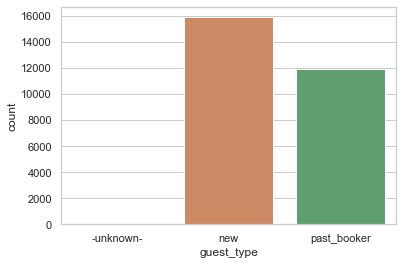

In [11]:
sns.barplot(x='guest_type', y='count', data=guest_cnt_df);

There are more new users compared to returning users. Let's visualize how each user group books their listing.
- **contact_me**: Guests writes a message to the host to inquire about the listing and host can either reject, accept, or respond meesage back to guests without explicit acceptance or rejection. 
- **book_it**: Guests puts down the money directly to the host and host accepts or rejects reservation requests.
- **instant_book**: The guest books the listing directly without any approval from the host (auto-accepted by the host).

In [12]:
# Group by user group
grp_df = contacts_df.groupby(['guest_user_stage_first'])

# Count based on contact channel's values per each user group
new_users_series = grp_df.get_group('new')['contact_channel_first'].value_counts().sort_index()
return_users_series = grp_df.get_group('past_booker')['contact_channel_first'].value_counts().sort_index()
unknown_users_series = grp_df.get_group('-unknown-')['contact_channel_first'].value_counts().sort_index()

# Create dataframe to be used for plotting
new_users_df = pd.DataFrame({'contact_channels': new_users_series.index, 'count': new_users_series.values})
return_users_df = pd.DataFrame({'contact_channels': return_users_series.index, 'count': return_users_series.values})
unknown_users_df = pd.DataFrame({'contact_channels': unknown_users_series.index, 'count': unknown_users_series.values})

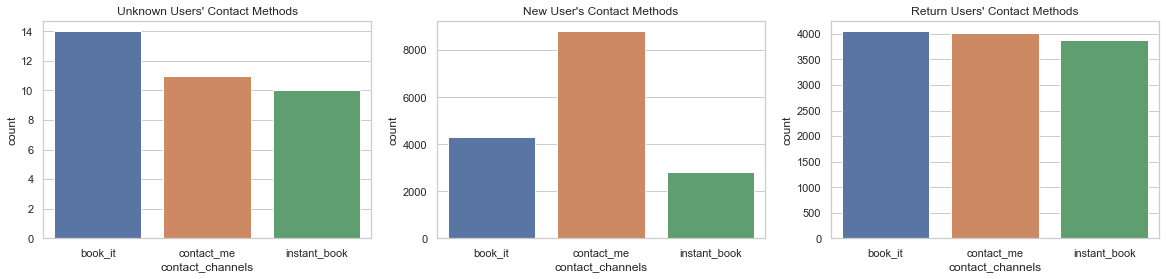

In [13]:
plt.figure(figsize=(20,4)) # width and height in inches

# Unknown users group
ax_one = plt.subplot(1,3,1) # nrows, ncols, index
sns.barplot(x='contact_channels', y='count', data=unknown_users_df, ax=ax_one)
ax_one.set(xlabel='contact_channels', ylabel='count', title="Unknown Users' Contact Methods")

# New users group
ax_two = plt.subplot(1,3,2)
sns.barplot(x='contact_channels', y='count', data=new_users_df, ax=ax_two)
ax_two.set(xlabel='contact_channels', ylabel='count', title="New User's Contact Methods");

# Return users group
ax_three = plt.subplot(1,3,3)
sns.barplot(x='contact_channels', y='count', data=return_users_df, ax=ax_three)
ax_three.set(xlabel='contact_channels', ylabel='count', title="Return Users' Contact Methods");

Majority of unknown and return user groups book listing through *book_it* where guest puts money down without inquiry and awaits for host to accept or reject while new user group uses *contact_me* which is booking through inquiry. It's also interesting to note that new user rarely uses *instant_book* feature compared to other two user groups, presumably because new users are unsure of the platform or its services.

### 2.3 Visualizing three different user groups' booking experience (inquiry to booking)
I will be inspecting four columns and identify which part of booking cycle where guest get dropped off without completing the booking:
- **ts_interaction_first**: Moment the inquiry is made the guest.
- **ts_reply_at_first**: Moment the host replies to the inquiry.
- **ts_accepted_at_first**: Moment host accepts the inquiry.
- **ts_booking_at**: Moment booking is made.

In [14]:
# Getting three dataframes representing user types (new, past_booker, unknown)
new_users_df = contacts_df[contacts_df['guest_user_stage_first'] == 'new']
return_users_df = contacts_df[contacts_df['guest_user_stage_first'] == 'past_booker']
unknown_users_df = contacts_df[contacts_df['guest_user_stage_first'] == '-unknown-']

In [15]:
# Counting number of rows that contains NaT values
def count_nats(df):
    '''
    Builds dataframe consisting of 4 columns related to booking cycle with NaT count values.
    
    Parameters
    ----------
    df: pandas.DataFrame
        contacts DataFrame
    Returns
    -------
    menu_df: pandas.DataFrame
        DataFrame with ts_interaction_first, ts_reply_at_first, ts_accepted_at_first, and ts_booking_at columns
    '''
    nat_count = df[df['ts_interaction_first'].isna()].shape[0]
    nat_count_two = df[df['ts_reply_at_first'].isna()].shape[0]
    nat_count_three = df[df['ts_accepted_at_first'].isna()].shape[0]
    nat_count_four = df[df['ts_booking_at'].isna()].shape[0]
    
    data = {'booking_cycle': ['ts_interaction_first', 'ts_reply_at_first', 'ts_accepted_at_first', 'ts_booking_at'],
            'count': [nat_count, nat_count_two, nat_count_three, nat_count_four]}
    
    guest_type = df['guest_user_stage_first'].values[0] # new, past_booker, -unknown-
    
    df = pd.DataFrame(data)
    df['guest_type'] = guest_type
    
    return df

In [16]:
new_users_df = count_nats(new_users_df)
return_users_df = count_nats(return_users_df)
unknown_users_df = count_nats(unknown_users_df)

In [17]:
# Combine all users dataframe
users_df = pd.concat([new_users_df, return_users_df, unknown_users_df]).reset_index(drop=True)
users_df

,booking_cycle,count,guest_type
0,ts_interaction_first,0,new
1,ts_reply_at_first,1269,new
2,ts_accepted_at_first,7274,new
3,ts_booking_at,10620,new
4,ts_interaction_first,0,past_booker
5,ts_reply_at_first,760,past_booker
6,ts_accepted_at_first,4181,past_booker
7,ts_booking_at,5659,past_booker
8,ts_interaction_first,0,-unknown-
9,ts_reply_at_first,3,-unknown-


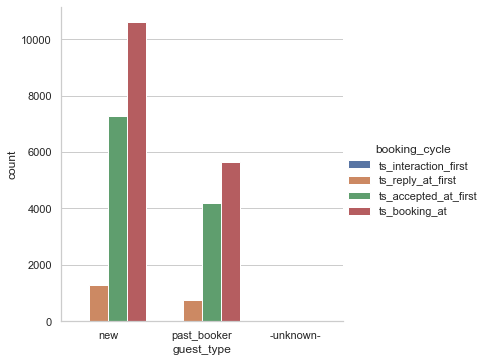

In [18]:
sns.catplot(x='guest_type', y='count', hue='booking_cycle', data=users_df, kind='bar');

Considering the above graph, there is a significant guest drop-off for new guests during booking experience in which new guests tend to use *contact_me* feature predominantly. I can inference that there is minor instances where host doesn't respond to guests in timely matter, host does not accept or reject guest's inquiry (follow-up issue), and guests not booking in the end after host responds and accepts the guest's inquiry.

With that being said, we have significant business opportunities to implement better system primarily for new guests whom seem to use *contact_me* feature.

### 2.4 Visualizing host response rate to guests' inquiries and text characteristics.
I will be inspecting how long it takes for host to respond in average to guests when using *contact_me* and *book_it* feature and check if long text count provide quicker response from the users.

In [40]:
# Find contact me response time - get ts_interaction_frst and ts_reply_at_first_column
contact_me_feat_df = contacts_df[contacts_df['contact_channel_first'] == 'contact_me'][['ts_interaction_first', 'ts_reply_at_first', 'ts_accepted_at_first', 'ts_booking_at']]
book_it_feat_df = contacts_df[contacts_df['contact_channel_first'] == 'book_it'][['ts_interaction_first', 'ts_reply_at_first', 'ts_accepted_at_first', 'ts_booking_at']]


# Get time difference between ts_interaction_first and ts_reply_at_first column
contact_me_feat_df['reply_response_mins'] = (contact_me_feat_df['ts_reply_at_first']-contact_me_feat_df['ts_interaction_first']).astype('timedelta64[m]')
book_it_feat_df['reply_response_mins'] = (book_it_feat_df['ts_reply_at_first']-book_it_feat_df['ts_interaction_first']).astype('timedelta64[m]')
contact_me_feat_df['accepted_response_mins'] = (contact_me_feat_df['ts_accepted_at_first']-contact_me_feat_df['ts_reply_at_first']).astype('timedelta64[m]')
book_it_feat_df['accepted_response_mins'] = (book_it_feat_df['ts_accepted_at_first']-book_it_feat_df['ts_reply_at_first']).astype('timedelta64[m]')
contact_me_feat_df['booking_response_mins'] = (contact_me_feat_df['ts_booking_at']-contact_me_feat_df['ts_accepted_at_first']).astype('timedelta64[m]')
book_it_feat_df['booking_response_mins'] = (book_it_feat_df['ts_booking_at']-book_it_feat_df['ts_accepted_at_first']).astype('timedelta64[m]')
contact_me_feat_df['total_response_mins'] = (contact_me_feat_df['ts_booking_at']-contact_me_feat_df['ts_reply_at_first']).astype('timedelta64[m]')
book_it_feat_df['total_response_mins'] = (book_it_feat_df['ts_booking_at']-book_it_feat_df['ts_reply_at_first']).astype('timedelta64[m]')

In [69]:
def get_average_response_time(df, feat_type):
    '''
    Builds dataframe consisting of 4 columns related to average response time.
    
    Parameters
    ----------
    df: pandas.DataFrame
        contact_me or book_it DataFrame
    feat_type: str
        contact_me or book_it
    Returns
    -------
    df: pandas.DataFrame
        DataFrame with average response time columns
    '''
    # Remove NaT/NaNs and find time difference and average out the responsse time in minutes
    reply_response = df[df['reply_response_mins'].notnull()]['reply_response_mins'].mean()
    accepted_response = df[df['accepted_response_mins'].notnull()]['accepted_response_mins'].mean()
    book_it_response = df[df['booking_response_mins'].notnull()]['booking_response_mins'].mean()
    total_response = df[df['total_response_mins'].notnull()]['total_response_mins'].mean()

    data = {'response_type': ['reply_response', 'accepted_response', 'book_it_response', 'total_response'],
            'avg_response_mins': [reply_response, accepted_response, book_it_response, total_response]}

    df = pd.DataFrame(data)
    df['feat_type'] = feat_type

    return df

In [72]:
# Get average time per time response columns
contact_feat_df = get_average_response_time(contact_me_feat_df, 'contact_me')
book_feat_df = get_average_response_time(book_it_feat_df, 'book_it')

In [75]:
# Combine all users dataframe
time_df = pd.concat([contact_feat_df, book_feat_df]).reset_index(drop=True)
time_df

,response_type,avg_response_mins,feat_type
0,reply_response,1390.028905,contact_me
1,accepted_response,789.640460,contact_me
2,book_it_response,3318.765093,contact_me
3,total_response,4602.890231,contact_me
4,reply_response,817.114221,book_it
5,accepted_response,728.740094,book_it
6,book_it_response,28.920663,book_it
7,total_response,634.737384,book_it


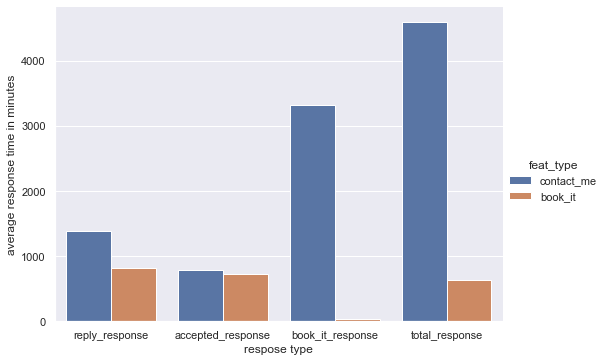

In [89]:
ax = sns.catplot(x='response_type', y='avg_response_mins', hue='feat_type', data=time_df, kind='bar', height=5, aspect=11.7/8.27);
ax.set(xlabel="respose type", ylabel="average response time in minutes");

From above visualization, you can see that users who uses contact_me feature in general have higher response time compared to book_it feature, which explains why it has higher guest drop off - which ultimately does not book the room.

### 2.4 Visualizing whether more interactions yields higher response/acceptance/booking rate.
Analyzing whether more interations between host and guests yields higher likelihood of response, acceptance, and booking confirmation. 